In [116]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [64]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Dataset Analysis

In [101]:
df = pd.read_csv("data/train.csv")
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


- survival -> Survival	0 = No, 1 = Yes
- pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
- sex	Sex	
- Age	Age in years	
- sibsp	# of siblings / spouses aboard the Titanic	
- parch	# of parents / children aboard the Titanic	
- ticket	Ticket number	
- fare	Passenger fare	
- cabin	Cabin number	
- embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [66]:
df_survived = df.loc[df["Survived"] == 1, :]
df_dead = df.loc[df["Survived"] == 0, :]


## Missing Data

In [67]:
print("Age")
print("	Part of passengers with no information on the age", round((sum(df["Age"].isna()) /  df["Age"].shape[0]) * 100, 2),"%")
print("	Part of survived passengers with no information on the age", round((sum(df_survived["Age"].isna()) /  df_survived["Age"].shape[0]) * 100, 2),"%")
print("	Part of dead passengers with no information on the age", round((sum(df_dead["Age"].isna()) /  df_dead["Age"].shape[0]) * 100, 2),"%")

print()
print("Passenger Class")
print("	Part of passengers with no information on the Class", round((sum(df["Pclass"].isna()) /  df["Pclass"].shape[0]) * 100, 2),"%")

print()
print("Sex")
print("	Part of passengers with no information on the Sex", round((sum(df["Sex"].isna()) /  df["Sex"].shape[0]) * 100, 2),"%")

print()
print("Siblings spouses aboard the Titanic")
print("	Part of passengers with no information on the Siblings spouses aboard the Titanic", round((sum(df["SibSp"].isna()) /  df["SibSp"].shape[0]) * 100, 2),"%")

print()
print("Parents or children aboard the Titanic")
print("	Part of passengers with no information on the Parents or children aboard the Titanic", round((sum(df["Parch"].isna()) /  df["Parch"].shape[0]) * 100, 2),"%")

print()
print("Fare")
print("	Part of passengers with no information on the Fare", round((sum(df["Fare"].isna()) /  df["Fare"].shape[0]) * 100, 2),"%")

print()
print("Cabin")
print("	Part of passengers with no information on the Cabin", round((sum(df["Cabin"].isna()) /  df["Cabin"].shape[0]) * 100, 2),"%")
print("	Part of survived passengers with no information on the Cabin", round((sum(df_survived["Cabin"].isna()) /  df_survived["Cabin"].shape[0]) * 100, 2),"%")
print("	Part of dead passengers with no information on the Cabin", round((sum(df_dead["Cabin"].isna()) /  df_dead["Cabin"].shape[0]) * 100, 2),"%")

print()
print("Embarked")
print("	Part of passengers with no information on the Embarked", round((sum(df["Embarked"].isna()) /  df["Embarked"].shape[0]) * 100, 2),"%")



Age
	Part of passengers with no information on the age 19.87 %
	Part of survived passengers with no information on the age 15.2 %
	Part of dead passengers with no information on the age 22.77 %

Passenger Class
	Part of passengers with no information on the Class 0.0 %

Sex
	Part of passengers with no information on the Sex 0.0 %

Siblings spouses aboard the Titanic
	Part of passengers with no information on the Siblings spouses aboard the Titanic 0.0 %

Parents or children aboard the Titanic
	Part of passengers with no information on the Parents or children aboard the Titanic 0.0 %

Fare
	Part of passengers with no information on the Fare 0.0 %

Cabin
	Part of passengers with no information on the Cabin 77.1 %
	Part of survived passengers with no information on the Cabin 60.23 %
	Part of dead passengers with no information on the Cabin 87.61 %

Embarked
	Part of passengers with no information on the Embarked 0.22 %


There is too much missing data on the Cabin, I won't be using it now.

## Gender and Passenger Class

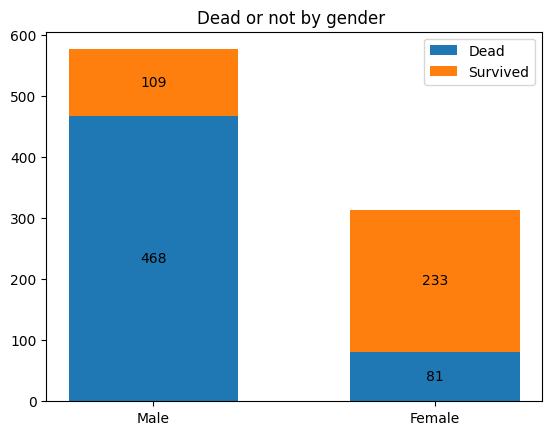

In [68]:
gender = ('Male', 'Female')
counts = {
    'Dead': np.array([ sum(df_dead["Sex"] == "male"), sum(df_dead["Sex"] == "female")]),
    'Survived': np.array([sum(df_survived["Sex"] == "male"), sum(df_survived["Sex"] == "female")]),
}
width = 0.6  # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
bottom = np.zeros(2)
for output, count in counts.items():
    p = ax.bar(gender, count, width, label=output, bottom=bottom)
    bottom += count

    ax.bar_label(p, label_type='center')

ax.set_title('Dead or not by gender ')
ax.legend()
plt.show()

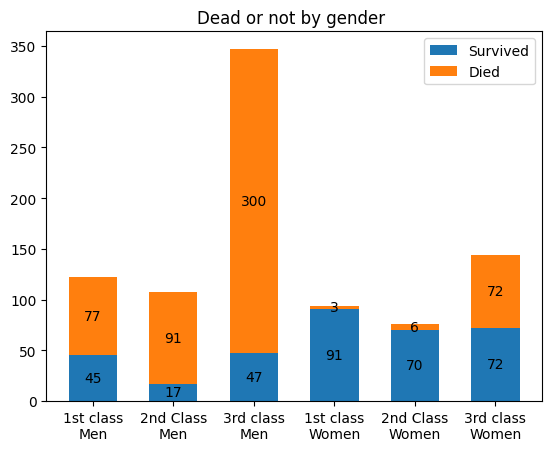

In [69]:
men_ok = df_survived[df_survived["Sex"] == "male"]
men_ko = df_dead[df_dead["Sex"] == "male"]
women_ok = df_survived[df_survived["Sex"] == "female"]
women_ko = df_dead[df_dead["Sex"] == "female"]

class_passenger = ('1st class\nMen', '2nd Class\nMen', "3rd class\nMen", '1st class\nWomen', '2nd Class\nWomen', "3rd class\nWomen")
counts = {
    'Survived': np.array([sum(men_ok["Pclass"] == 1),
                          sum(men_ok["Pclass"] == 2),
                          sum(men_ok["Pclass"] == 3),
                          sum(women_ok["Pclass"] == 1),
                          sum(women_ok["Pclass"] == 2),
                          sum(women_ok["Pclass"] == 3)]),
    'Died': np.array([sum(men_ko["Pclass"] == 1),
                      sum(men_ko["Pclass"] == 2),
                      sum(men_ko["Pclass"] == 3),
                      sum(women_ko["Pclass"] == 1),
                      sum(women_ko["Pclass"] == 2),
                      sum(women_ko["Pclass"] == 3)]),
}
width = 0.6
fig, ax = plt.subplots()
bottom = np.zeros(6)
for output, count in counts.items():
    p = ax.bar(class_passenger, count, width, label=output, bottom=bottom)
    bottom += count

    ax.bar_label(p, label_type='center')

ax.set_title('Dead or not by gender ')
ax.legend()
plt.show()

Obviously, gender and passenger class have a very strong impact on the likeliness to survive

## Age

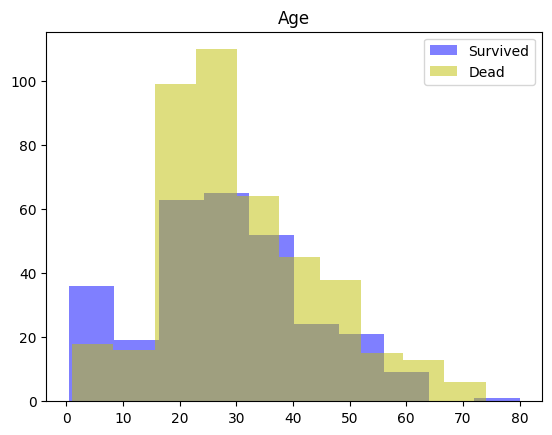

In [70]:
df_survived_with_age = df_survived.loc[df_survived["Age"].isna() == False]
df_dead_with_age = df_dead.loc[df_dead["Age"].isna() == False]

plt.title("Age")
plt.hist(df_survived_with_age.loc[:,"Age"], alpha = 0.5, lw=3, label="Survived", color="b")
plt.hist(df_dead_with_age.loc[:,"Age"], alpha = 0.5, lw=3, label="Dead", color="y")

plt.legend()
plt.show()

The age seems to have a strong impact on survival rate, estpecialy for young children, 20 to 30. I may try to train the model by replacing the missing age values by the mean of the dataset. Or by not using these values. 

# Fare

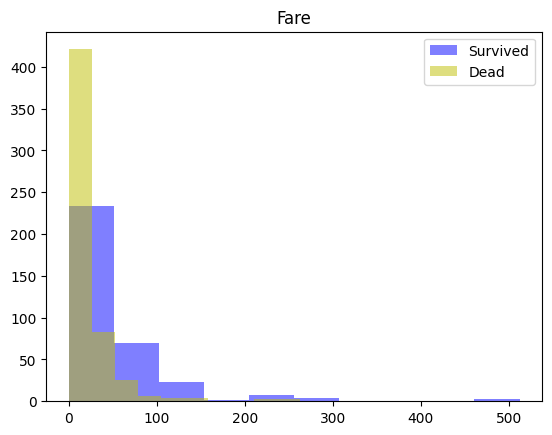

In [71]:
plt.title("Fare")
plt.hist(df_survived.loc[:,"Fare"], alpha = 0.5, lw=3, label="Survived", color="b")
plt.hist(df_dead.loc[:,"Fare"], alpha = 0.5, lw=3, label="Dead", color="y")

plt.legend()
plt.show()

### Embarked port

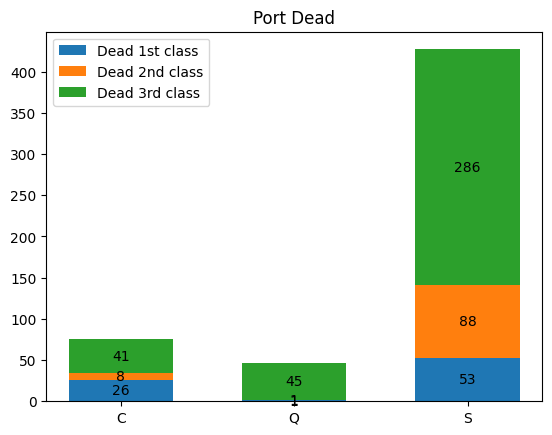

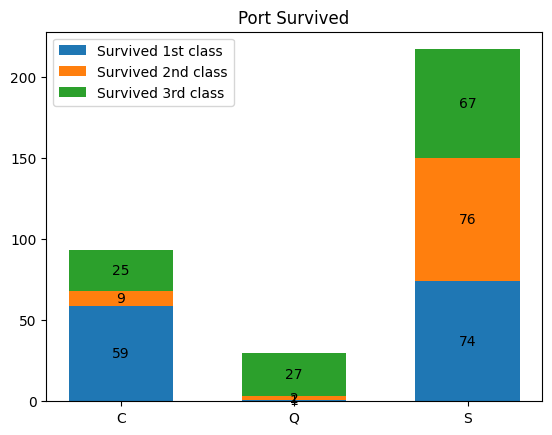

In [72]:
dead_c_1 = df.loc[(df["Embarked"] == "C") & (df["Pclass"] == 1) & (df["Survived"] == 0)].shape[0]
dead_c_2 = df.loc[(df["Embarked"] == "C") & (df["Pclass"] == 2) & (df["Survived"] == 0)].shape[0]
dead_c_3 = df.loc[(df["Embarked"] == "C") & (df["Pclass"] == 3) & (df["Survived"] == 0)].shape[0]
dead_q_1 = df.loc[(df["Embarked"] == "Q") & (df["Pclass"] == 1) & (df["Survived"] == 0)].shape[0]
dead_q_2 = df.loc[(df["Embarked"] == "Q") & (df["Pclass"] == 2) & (df["Survived"] == 0)].shape[0]
dead_q_3 = df.loc[(df["Embarked"] == "Q") & (df["Pclass"] == 3) & (df["Survived"] == 0)].shape[0]
dead_s_1 = df.loc[(df["Embarked"] == "S") & (df["Pclass"] == 1) & (df["Survived"] == 0)].shape[0]
dead_s_2 = df.loc[(df["Embarked"] == "S") & (df["Pclass"] == 2) & (df["Survived"] == 0)].shape[0]
dead_s_3 = df.loc[(df["Embarked"] == "S") & (df["Pclass"] == 3) & (df["Survived"] == 0)].shape[0]

survived_c_1 = df.loc[(df["Embarked"] == "C") & (df["Pclass"] == 1) & (df["Survived"] == 1)].shape[0]
survived_c_2 = df.loc[(df["Embarked"] == "C") & (df["Pclass"] == 2) & (df["Survived"] == 1)].shape[0]
survived_c_3 = df.loc[(df["Embarked"] == "C") & (df["Pclass"] == 3) & (df["Survived"] == 1)].shape[0]
survived_q_1 = df.loc[(df["Embarked"] == "Q") & (df["Pclass"] == 1) & (df["Survived"] == 1)].shape[0]
survived_q_2 = df.loc[(df["Embarked"] == "Q") & (df["Pclass"] == 2) & (df["Survived"] == 1)].shape[0]
survived_q_3 = df.loc[(df["Embarked"] == "Q") & (df["Pclass"] == 3) & (df["Survived"] == 1)].shape[0]
survived_s_1 = df.loc[(df["Embarked"] == "S") & (df["Pclass"] == 1) & (df["Survived"] == 1)].shape[0]
survived_s_2 = df.loc[(df["Embarked"] == "S") & (df["Pclass"] == 2) & (df["Survived"] == 1)].shape[0]
survived_s_3 = df.loc[(df["Embarked"] == "S") & (df["Pclass"] == 3) & (df["Survived"] == 1)].shape[0]

port = ('C', 'Q', 'S')
counts = {
    'Dead 1st class': np.array([dead_c_1, dead_q_1, dead_s_1]),
    'Dead 2nd class': np.array([dead_c_2, dead_q_2, dead_s_2]),
    'Dead 3rd class': np.array([dead_c_3, dead_q_3, dead_s_3]),
}
width = 0.6  # the width of the bars: can also be len(x) sequence
fig, ax = plt.subplots()
bottom = np.zeros(3)
for output, count in counts.items():
    p = ax.bar(port, count, width, label=output, bottom=bottom)
    bottom += count
    ax.bar_label(p, label_type='center')
ax.set_title('Port Dead')
ax.legend()
plt.show()

port = ('C', 'Q', 'S')
counts = {
    'Survived 1st class': np.array([survived_c_1, survived_q_1, survived_s_1]),
    'Survived 2nd class': np.array([survived_c_2, survived_q_2, survived_s_2]),
    'Survived 3rd class': np.array([survived_c_3, survived_q_3, survived_s_3]),
}
width = 0.6  # the width of the bars: can also be len(x) sequence
fig, ax = plt.subplots()
bottom = np.zeros(3)
for output, count in counts.items():
    p = ax.bar(port, count, width, label=output, bottom=bottom)
    bottom += count
    ax.bar_label(p, label_type='center')
ax.set_title('Port Survived')
ax.legend()
plt.show()

The ratio of survived and death is not the same for each port. This probably has an influence on the final result. 

# Transforming the Dataset

In [102]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [103]:
new_col = df.columns[:1].to_list() + df.columns[2:].to_list() + [df.columns[1]]
df = df[new_col]
df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0
887,888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,0
889,890,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,1


In [104]:
(X_train, X_valid, y_train, y_valid) = train_test_split(df.loc[:, "PassengerId":"Embarked"],
                                                        df.loc[:, "Survived"],
                                                        test_size=0.2,
                                                        shuffle=True)

In [105]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((712, 11), (179, 11), (712,), (179,))

In [107]:
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
241,242,3,"Murphy, Miss. Katherine ""Kate""",female,NaN,1,0,367230,15.5000,NaN,Q
832,833,3,"Saad, Mr. Amin",male,NaN,0,0,2671,7.2292,NaN,C
871,872,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S
561,562,3,"Sivic, Mr. Husein",male,40.0,0,0,349251,7.8958,NaN,S
261,262,3,"Asplund, Master. Edvin Rojj Felix",male,3.0,4,2,347077,31.3875,NaN,S


In [108]:
# Define transforms on numeric types
numeric_features = ["Age", "Fare", "Pclass", "SibSp", "Parch"]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    ])

# Define transforms on categorical types
categorical_features = ["Sex", "Embarked"]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop="first"))])

# Construct ColumnTransformer object
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop',
    verbose=True)


In [109]:
X_train_processed = preprocessor.fit_transform(X_train)
X_train_processed.shape

[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s


(712, 9)

In [110]:
X_valid_processed = preprocessor.transform(X_valid)
X_valid_processed.shape

(179, 9)

In [134]:
class MyDataset(Dataset):
    def __init__(self, data, name="dataset") -> None:
        super().__init__()
        self.name = name
        features, target = data
        self.features = features
        self.n_samples = len(self.features)
        if target is not None:
            self.target = np.array(target)
        else:
            self.target = (-1) * np.ones(self.n_samples, dtype=np.int32)

    def __getitem__(self, index):
        return (self.features[index], self.target[index])
    
    def __len__(self):
        return self.n_samples
    
    def get_stats(self):
        print('--------------------')
        print(self.name)
        for val, nb in np.array(np.unique(self.target , return_counts=True)).T:
            print(f"{val}   {nb}")
        print('--------------------')

In [135]:
train_dataset = MyDataset((X_train_processed, y_train), name="Train")
val_dataset = MyDataset((X_valid_processed, y_valid), name="Val")


In [136]:
train_dataset.get_stats()
val_dataset.get_stats()

--------------------
Train
0   446
1   266
--------------------
--------------------
Val
0   103
1   76
--------------------


In [182]:
def collate_batch(batch):
    """
    Input:
        batch : list of (features, label)
    Output:
        (features, label) (both torch.tensor)
    """

    features = np.array([elem[0] for elem in batch])
    features = torch.tensor(features, dtype=torch.float32).to(device)
    label = torch.tensor(np.array([elem[1] for elem in batch]).reshape(len(features), 1), dtype=torch.float32).to(device)
    return features, label

In [183]:
dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch)

In [184]:
with torch.no_grad():
        for features, label in dataloader:
            print(features)
            print(label)
            break


tensor([[-0.4603, -0.5107,  0.8186, -0.4763, -0.4599,  1.0000,  0.0000,  0.0000,
          0.0000],
        [-1.1436, -0.3610,  0.8186,  0.4068, -0.4599,  0.0000,  0.0000,  0.0000,
          0.0000],
        [-0.0427, -0.0390, -1.5653, -0.4763, -0.4599,  1.0000,  0.0000,  1.0000,
          0.0000],
        [-0.1186, -0.4969,  0.8186, -0.4763, -0.4599,  1.0000,  0.0000,  1.0000,
          0.0000],
        [-0.4223,  0.7752, -1.5653, -0.4763, -0.4599,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.4129, -0.1219, -0.3733, -0.4763, -0.4599,  1.0000,  0.0000,  1.0000,
          0.0000],
        [-0.1186, -0.3622,  0.8186,  0.4068,  0.7757,  0.0000,  0.0000,  1.0000,
          0.0000],
        [-0.0427, -0.4994,  0.8186, -0.4763, -0.4599,  1.0000,  0.0000,  1.0000,
          0.0000],
        [-2.1876, -0.2615,  0.8186,  1.2900,  0.7757,  0.0000,  0.0000,  0.0000,
          0.0000],
        [-0.5742, -0.4668,  0.8186, -0.4763, -0.4599,  1.0000,  0.0000,  1.0000,
          0.0000],


# Modeles

In [185]:
class SimpleLogisticRegression(nn.Module):
	"""
	My simple logistic regression model
	"""
	def __init__(self, input_size, output_size=1) -> None:
		super(SimpleLogisticRegression, self).__init__()
		self.linear = nn.Linear(input_size, output_size)

	def forward(self, x):
		result = self.linear(x)
		return torch.sigmoid(result)


In [186]:
class SimpleNeuralNetwork(nn.Module):
	"""
	A simple Neural Network
	"""
	def __init__(self, input_size, output_size=1, hidden_layer_size=32) -> None:
		super(SimpleNeuralNetwork, self).__init__()
		self.hidden_1 = nn.Linear(input_size, hidden_layer_size)
		self.outputLayer = nn.Linear(hidden_layer_size, output_size)
	
	def forward(self, x):
		x = torch.sigmoid(self.hidden_1(x))
		return torch.sigmoid(self.outputLayer(x))


In [194]:
def compute_acc(model, dataloader):
    """
    Input:
        model: a Pytorch NN.Model
        dataloader: a Pytorch datamodel
    Output:
        The accuracy of the model 
    """
    model.eval()
    true = []
    total_num = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            probs = model(X_batch)
            y_hat = (probs >= 0.5).int()
            y_batch = torch.reshape(y_batch, (y_batch.shape[0],))
            y_hat = torch.reshape(y_hat, (y_hat.shape[0],))
            test = y_hat == y_batch
            true.append(sum(test).tolist())
            total_num.append(len(y_batch))
    acc = (sum(true) / sum(total_num)) * 100
    return acc


In [195]:
def compute_loss(loss, model, dataloader):
    """
    Input:
        loss: The loss functon to use
        model: a Pytorch NN.Model
        dataloader: a Pytorch datamodel
    Output:
        The average loss of the model on a set of data
    """
    model.eval()
    all_losses = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            probs = model(X_batch)
            y_batch = y_batch.type(torch.float32)
            all_losses.append(loss(probs, y_batch).item())
    return np.mean(all_losses)

In [239]:
def train_model(model, optimizer, dataloader, val_dataloader, n_epochs=10, loss_fn=nn.BCELoss(), 
                train_loss=None, val_loss=None, acc_train=None, acc_val=None):
    """
    Input:
        model: a Pytorch NN.Model
        optimizer: Pytorch optimizer initiated for the model
        dataloader: The Pytorch dataloader for trainning
        val_dataloader: The Pytorch dataloader for validation
        n_epochs=10 : The number of epochs for the trainning
        loss_fn=nn.BCEWithLogitsLoss() : The function used to train the model
        train_loss (list): list used to store the train loss of each epoch
        val_loss (list): list used to store the validation loss of each epoch
        acc_train (list): list used to store the train accuracy of each epoch
        acc_val (list): list used to store the validation accuracy of each epoch
    Output:
        train_loss (list): input train_loss with the new values appended
        val_loss (list): input val_loss with the new values appended
        acc_train (list): input acc_train with the new values appended
        acc_val (list): input acc_val with the new values appended
    """
    if train_loss is None:
        train_loss = []
    if val_loss is None:
        val_loss = []
    if acc_train is None:
        acc_train = []
    if acc_val is None:
        acc_val = []
    for epoch in range(n_epochs):
        model.train()
        loss_tr = []
        for  idx, ( X_batch, y_batch) in enumerate(dataloader):
            optimizer.zero_grad()
            probs = model(X_batch)
            y_batch = y_batch.type(torch.float32)
            loss = loss_fn(probs, y_batch)
            loss_tr.append(loss.item())
            loss.backward()
            optimizer.step()
            model.zero_grad()
        train_loss.append(np.mean(loss_tr))
        val_loss.append(compute_loss(loss_fn, model, val_dataloader))
        acc_train.append(compute_acc(model, dataloader))
        acc_val.append(compute_acc(model, val_dataloader))
        
        print(f"Epoch: {epoch}, train_loss={train_loss[-1]:.4f}, val_loss={val_loss[-1]:.4f}, acc_train={acc_train[-1]:.4f}, acc_val={acc_val[-1]:.4f}")
    return train_loss, val_loss, acc_train, acc_val

In [200]:
def plot_trainning_metrics(train_loss, val_loss, acc_train, acc_val):
	"""
    Input:
        val_loss (list): list used to store the validation loss of each epoch
        acc_train (list): list used to store the train accuracy of each epoch
        acc_val (list): list used to store the validation accuracy of each epoch
    Output:
		No return values
    """
	x = range(len(train_loss))
	train_loss_round = np.round(train_loss, 3)
	val_loss_round = np.round(val_loss, 3)
	acc_train_round = np.round(acc_train, 3)
	acc_val_round = np.round(acc_val, 3)
	plt.figure(figsize=(13, 7))
	plt.subplot(1, 2, 1)
	plt.plot(x, train_loss_round, "b", label="Training Set")
	plt.plot(x, val_loss_round, "r", label="Validation Set")
	plt.xlabel("epoch")
	plt.ylabel("Loss")
	plt.legend()
	plt.title(f"Evolution of the loss")

	plt.subplot(1, 2, 2)
	plt.plot(x, acc_train_round, "b", label="Training Set")
	plt.plot(x, acc_val_round, "r", label="Validation Set")
	plt.xlabel("epoch")
	plt.ylabel("Accuracy")
	plt.legend()
	plt.title(f"Evolution of the Accuracy")
	
	plt.show()

## Model SimpleLogisticRegression Sans regularisation

In [203]:
model = SimpleLogisticRegression(X_train_processed.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [204]:
train_loss_history, val_loss_history, acc_train_history, acc_val_history = [], [], [], []

In [205]:
(train_loss_history,
 val_loss_history,
 acc_train_history,
 acc_val_history) = train_model(
	 model,
	 optimizer,
	 dataloader,
	 val_dataloader,
	 n_epochs=1000,
	 train_loss=train_loss_history,
	 val_loss=val_loss_history, 
	 acc_train=acc_train_history,
	 acc_val=acc_val_history)

Epoch: 0, train_loss=0.8690, val_loss=0.8361, acc_train=29.7753, acc_val=34.0782
Epoch: 1, train_loss=0.8504, val_loss=0.8164, acc_train=30.1966, acc_val=33.5196
Epoch: 2, train_loss=0.8158, val_loss=0.7936, acc_train=30.8989, acc_val=34.0782
Epoch: 3, train_loss=0.7970, val_loss=0.7840, acc_train=32.3034, acc_val=35.7542
Epoch: 4, train_loss=0.7810, val_loss=0.7627, acc_train=34.1292, acc_val=36.8715
Epoch: 5, train_loss=0.7653, val_loss=0.7505, acc_train=34.8315, acc_val=34.6369
Epoch: 6, train_loss=0.7435, val_loss=0.7357, acc_train=34.4101, acc_val=31.8436
Epoch: 7, train_loss=0.7243, val_loss=0.7214, acc_train=37.2191, acc_val=32.9609
Epoch: 8, train_loss=0.7124, val_loss=0.7096, acc_train=44.8034, acc_val=41.3408
Epoch: 9, train_loss=0.7022, val_loss=0.7059, acc_train=60.8146, acc_val=55.8659
Epoch: 10, train_loss=0.6898, val_loss=0.6898, acc_train=61.6573, acc_val=58.1006
Epoch: 11, train_loss=0.6821, val_loss=0.6831, acc_train=64.0449, acc_val=59.2179
Epoch: 12, train_loss=0.67

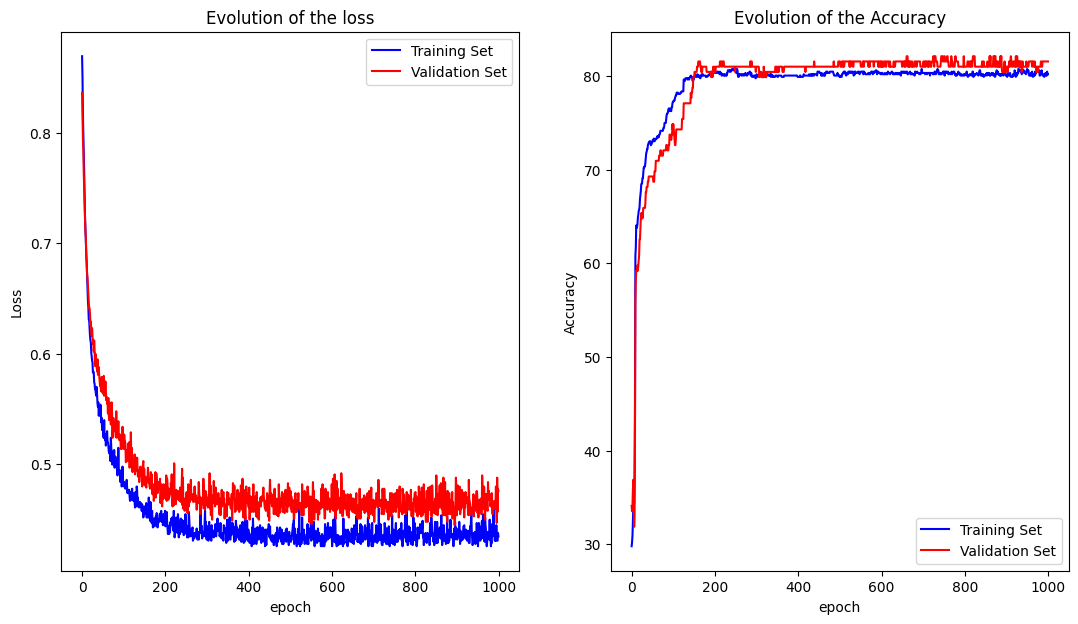

In [206]:
plot_trainning_metrics(train_loss_history, val_loss_history, acc_train_history, acc_val_history)

## Simple logistic regression with regularisation

In [240]:
model2 = SimpleLogisticRegression(X_train_processed.shape[1]).to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-3, weight_decay=0.01)

In [241]:
(train_loss_history2,
 val_loss_history2,
 acc_train_history2,
 acc_val_history2) = train_model(
	 model2,
	 optimizer2,
	 dataloader,
	 val_dataloader,
	 n_epochs=1000)

Epoch: 0, train_loss=0.8078, val_loss=0.7913, acc_train=34.1292, acc_val=35.1955
Epoch: 1, train_loss=0.7860, val_loss=0.7729, acc_train=35.1124, acc_val=35.1955
Epoch: 2, train_loss=0.7634, val_loss=0.7549, acc_train=35.6742, acc_val=35.7542
Epoch: 3, train_loss=0.7517, val_loss=0.7391, acc_train=38.7640, acc_val=39.6648
Epoch: 4, train_loss=0.7261, val_loss=0.7250, acc_train=44.2416, acc_val=43.0168
Epoch: 5, train_loss=0.7091, val_loss=0.7043, acc_train=50.9831, acc_val=47.4860
Epoch: 6, train_loss=0.6958, val_loss=0.6895, acc_train=60.3933, acc_val=59.2179
Epoch: 7, train_loss=0.6789, val_loss=0.6772, acc_train=65.5899, acc_val=62.5698
Epoch: 8, train_loss=0.6652, val_loss=0.6673, acc_train=66.8539, acc_val=65.3631
Epoch: 9, train_loss=0.6543, val_loss=0.6598, acc_train=67.2753, acc_val=64.2458
Epoch: 10, train_loss=0.6444, val_loss=0.6497, acc_train=67.5562, acc_val=64.8045
Epoch: 11, train_loss=0.6320, val_loss=0.6430, acc_train=66.5730, acc_val=65.3631
Epoch: 12, train_loss=0.62

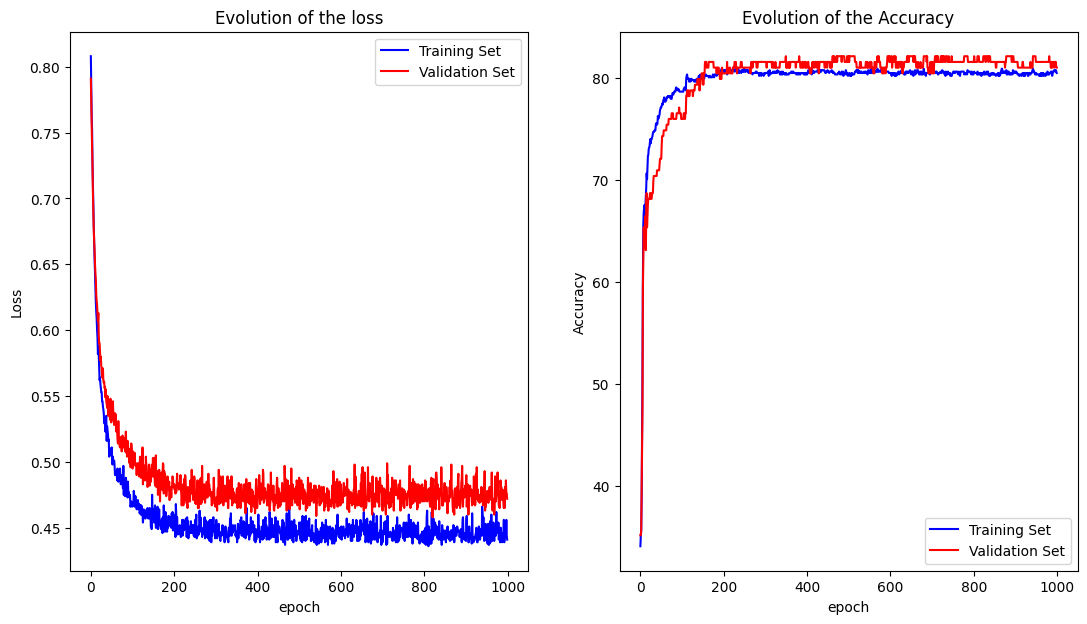

In [242]:
plot_trainning_metrics(train_loss_history2, val_loss_history2, acc_train_history2, acc_val_history2)

Pas de differences notables entre avec ou sans regularisation

## SimpleNeuralNetwork sans regularisation

In [276]:
model3 = SimpleNeuralNetwork(X_train_processed.shape[1]).to(device)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=1e-3)

In [277]:
(train_loss_history3,
 val_loss_history3,
 acc_train_history3,
 acc_val_history3) = train_model(
	 model3,
	 optimizer3,
	 dataloader,
	 val_dataloader,
	 n_epochs=500)

Epoch: 0, train_loss=0.6637, val_loss=0.6673, acc_train=63.2022, acc_val=58.1006
Epoch: 1, train_loss=0.6438, val_loss=0.6653, acc_train=62.9213, acc_val=58.1006
Epoch: 2, train_loss=0.6368, val_loss=0.6661, acc_train=63.2022, acc_val=58.1006
Epoch: 3, train_loss=0.6336, val_loss=0.6656, acc_train=63.6236, acc_val=57.5419
Epoch: 4, train_loss=0.6322, val_loss=0.6540, acc_train=64.0449, acc_val=56.9832
Epoch: 5, train_loss=0.6175, val_loss=0.6427, acc_train=64.4663, acc_val=59.2179
Epoch: 6, train_loss=0.6167, val_loss=0.6368, acc_train=65.4494, acc_val=60.8939
Epoch: 7, train_loss=0.6063, val_loss=0.6208, acc_train=66.8539, acc_val=63.1285
Epoch: 8, train_loss=0.5994, val_loss=0.6212, acc_train=68.8202, acc_val=65.9218
Epoch: 9, train_loss=0.5965, val_loss=0.6151, acc_train=70.3652, acc_val=65.3631
Epoch: 10, train_loss=0.5862, val_loss=0.6061, acc_train=71.3483, acc_val=67.0391
Epoch: 11, train_loss=0.5767, val_loss=0.6114, acc_train=71.9101, acc_val=67.0391
Epoch: 12, train_loss=0.56

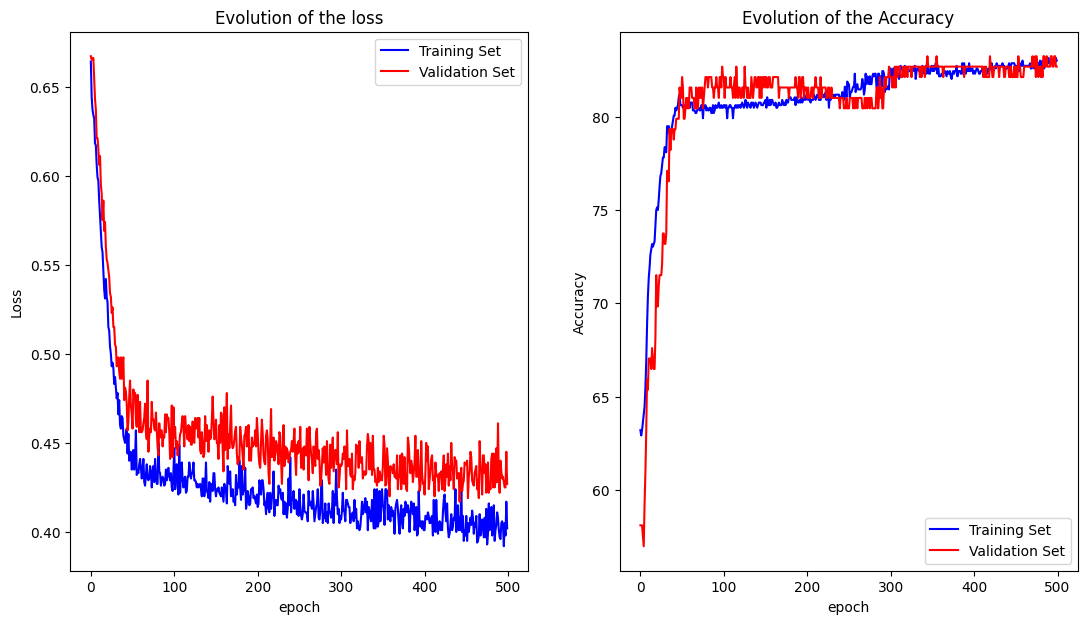

In [278]:
plot_trainning_metrics(train_loss_history3, val_loss_history3, acc_train_history3, acc_val_history3)

## SimpleNeuralNetwork avec regularisation

In [273]:
model4 = SimpleNeuralNetwork(X_train_processed.shape[1]).to(device)
optimizer4 = torch.optim.Adam(model4.parameters(), lr=1e-3, weight_decay=0.001)

In [274]:
(train_loss_history4, val_loss_history4,
 acc_train_history4, acc_val_history4) = train_model(
	 model4,
	 optimizer4,
	 dataloader,
	 val_dataloader,
	 n_epochs=200)

Epoch: 0, train_loss=0.6549, val_loss=0.6711, acc_train=62.6404, acc_val=57.5419
Epoch: 1, train_loss=0.6429, val_loss=0.6747, acc_train=62.6404, acc_val=57.5419
Epoch: 2, train_loss=0.6354, val_loss=0.6626, acc_train=62.6404, acc_val=57.5419
Epoch: 3, train_loss=0.6332, val_loss=0.6555, acc_train=62.6404, acc_val=57.5419
Epoch: 4, train_loss=0.6260, val_loss=0.6434, acc_train=63.9045, acc_val=58.1006
Epoch: 5, train_loss=0.6185, val_loss=0.6494, acc_train=64.0449, acc_val=58.6592
Epoch: 6, train_loss=0.6046, val_loss=0.6391, acc_train=66.1517, acc_val=62.5698
Epoch: 7, train_loss=0.6006, val_loss=0.6273, acc_train=67.5562, acc_val=64.2458
Epoch: 8, train_loss=0.5933, val_loss=0.6150, acc_train=70.2247, acc_val=65.3631
Epoch: 9, train_loss=0.5843, val_loss=0.6181, acc_train=70.7865, acc_val=65.3631
Epoch: 10, train_loss=0.5815, val_loss=0.6147, acc_train=71.7697, acc_val=66.4804
Epoch: 11, train_loss=0.5758, val_loss=0.5955, acc_train=72.0506, acc_val=66.4804
Epoch: 12, train_loss=0.56

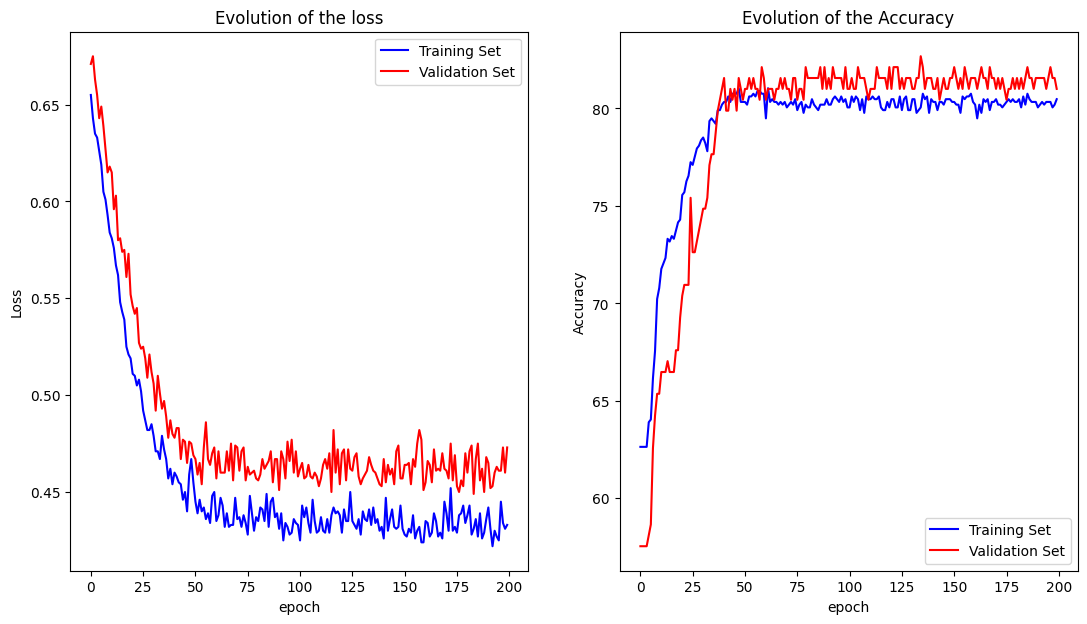

In [275]:
plot_trainning_metrics(train_loss_history4, val_loss_history4, acc_train_history4, acc_val_history4)

Epoch: 0, train_loss=0.6590, val_loss=0.6676, acc_train=62.6404, acc_val=57.5419
Epoch: 1, train_loss=0.6378, val_loss=0.6703, acc_train=62.6404, acc_val=57.5419
Epoch: 2, train_loss=0.6271, val_loss=0.6568, acc_train=63.4831, acc_val=58.1006
Epoch: 3, train_loss=0.6188, val_loss=0.6389, acc_train=63.9045, acc_val=57.5419
Epoch: 4, train_loss=0.6153, val_loss=0.6405, acc_train=65.5899, acc_val=61.4525
Epoch: 5, train_loss=0.6035, val_loss=0.6317, acc_train=67.5562, acc_val=64.8045
Epoch: 6, train_loss=0.5958, val_loss=0.6174, acc_train=70.2247, acc_val=65.9218
Epoch: 7, train_loss=0.5857, val_loss=0.6177, acc_train=71.6292, acc_val=66.4804
Epoch: 8, train_loss=0.5743, val_loss=0.6044, acc_train=71.9101, acc_val=66.4804
Epoch: 9, train_loss=0.5624, val_loss=0.5944, acc_train=73.1742, acc_val=65.9218
Epoch: 10, train_loss=0.5587, val_loss=0.5868, acc_train=73.0337, acc_val=66.4804
Epoch: 11, train_loss=0.5489, val_loss=0.5783, acc_train=73.0337, acc_val=67.0391
Epoch: 12, train_loss=0.54

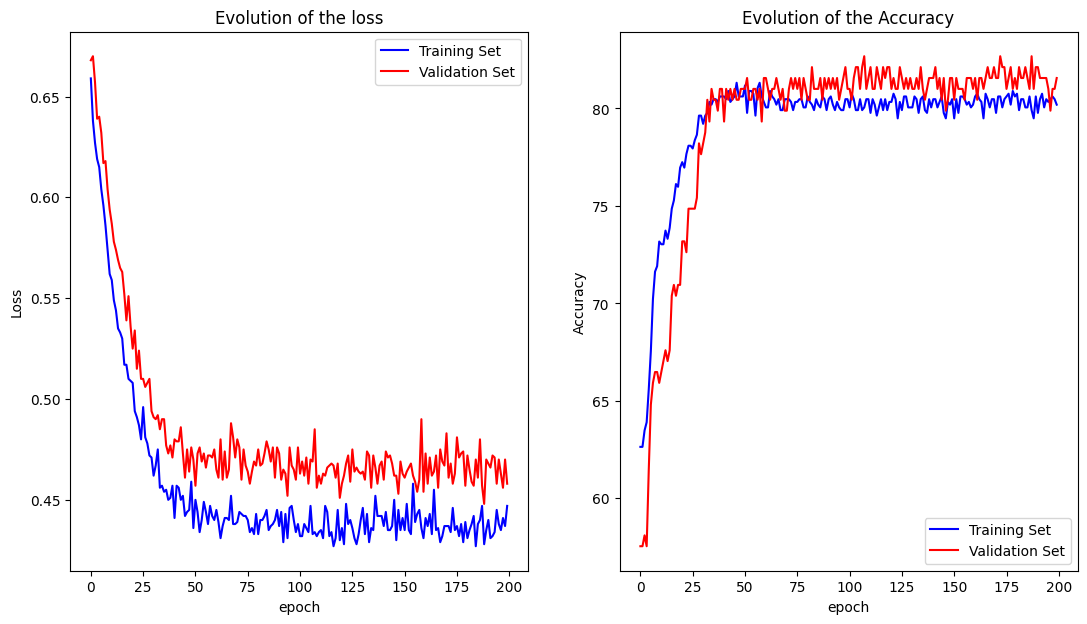

In [270]:
model5 = SimpleNeuralNetwork(X_train_processed.shape[1], hidden_layer_size=64).to(device)
optimizer5 = torch.optim.Adam(model5.parameters(), lr=1e-3, weight_decay=0.002)

(train_loss_history5, val_loss_history5,
 acc_train_history5, acc_val_history5) = train_model(
	 model5,
	 optimizer5,
	 dataloader,
	 val_dataloader,
	 n_epochs=200)

plot_trainning_metrics(train_loss_history5, val_loss_history5, acc_train_history5, acc_val_history5)

# Random Forest

In [279]:
from sklearn.ensemble import RandomForestClassifier

In [280]:
X_train_processed

array([[-0.11860726, -0.33937565,  0.81862017, ...,  1.        ,
         0.        ,  0.        ],
       [-0.11860726, -0.51071793,  0.81862017, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.3239812 ,  0.42825885, -1.56525533, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.65008722,  0.86218318, -0.37331758, ...,  0.        ,
         1.        ,  0.        ],
       [-1.63712142, -0.11667293, -0.37331758, ...,  0.        ,
         1.        ,  0.        ],
       [-1.10564147, -0.51080494,  0.81862017, ...,  0.        ,
         0.        ,  0.        ]])

In [294]:
rf_Model = RandomForestClassifier(warm_start=True, oob_score=True,)

In [295]:
rf_Model.fit(X_train_processed, y_train,)

RandomForestClassifier(oob_score=True, warm_start=True)

In [298]:
print("Train accuracy", rf_Model.oob_score_)

Train accuracy 0.8089887640449438


In [300]:
rf_val_pred = rf_Model.predict(X_valid_processed)

In [307]:
rf_val_acc = sum(rf_val_pred == y_valid)/len(y_valid)
print("Val accuracy", rf_val_acc)

Val accuracy 0.8044692737430168


# Prediction for the test

In [309]:
df_test = pd.read_csv("data/test.csv")
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [311]:
X_test_processed = preprocessor.transform(df_test)

In [312]:
X_test_processed

array([[ 0.37490984, -0.49828802,  0.81862017, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.3239812 , -0.51546616,  0.81862017, ...,  0.        ,
         1.        ,  0.        ],
       [ 2.46286682, -0.45979049, -0.37331758, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.67861268, -0.51028703,  0.81862017, ...,  0.        ,
         1.        ,  0.        ],
       [-0.11860726, -0.49371381,  0.81862017, ...,  0.        ,
         1.        ,  0.        ],
       [-0.11860726, -0.19729546,  0.81862017, ...,  0.        ,
         0.        ,  0.        ]])

In [326]:
def get_prediction_model_torch(model, x):
    model.eval()
    with torch.no_grad():
        probs = model(torch.tensor(x, dtype=torch.float32))
        y_hat = (probs >= 0.5).int()
        y_hat = torch.reshape(y_hat, (y_hat.shape[0],))
    return np.array(y_hat.tolist())

In [327]:
y_test_model1 = get_prediction_model_torch(model, X_test_processed)
y_test_model2 = get_prediction_model_torch(model2, X_test_processed)
y_test_model3 = get_prediction_model_torch(model3, X_test_processed)
y_test_model4 = get_prediction_model_torch(model4, X_test_processed)
y_test_model5 = get_prediction_model_torch(model5, X_test_processed)

In [328]:
y_test_rf = rf_Model.predict(X_test_processed)

In [329]:
y_test_rf.shape

(418,)

In [331]:
y_test_model5.shape

(418,)

In [335]:
data = {
    "id":df_test["PassengerId"], 
    "Model_1":y_test_model1, 
    "Model_2":y_test_model2, 
    "Model_3":y_test_model3,
    "Model_4":y_test_model4,
    "Model_5":y_test_model5,
    "RF":y_test_rf
}

In [354]:
result_consolide = pd.DataFrame(data)
result_consolide

,id,Model_1,Model_2,Model_3,Model_4,Model_5,RF
0,892,0,0,0,0,0,0
1,893,0,0,0,0,0,0
2,894,0,0,0,0,0,0
3,895,0,0,0,0,0,1
4,896,1,0,0,1,1,0
...,...,...,...,...,...,...,...
413,1305,0,0,0,0,0,0
414,1306,1,1,1,1,1,1
415,1307,0,0,0,0,0,0
416,1308,0,0,0,0,0,0


In [355]:
result_consolide["Total"] = (result_consolide.iloc[:,1:].sum(axis=1) / result_consolide.iloc[:,1:].shape[1])
result_consolide

,id,Model_1,Model_2,Model_3,Model_4,Model_5,RF,Total
0,892,0,0,0,0,0,0,0.000000
1,893,0,0,0,0,0,0,0.000000
2,894,0,0,0,0,0,0,0.000000
3,895,0,0,0,0,0,1,0.166667
4,896,1,0,0,1,1,0,0.500000
...,...,...,...,...,...,...,...,...
413,1305,0,0,0,0,0,0,0.000000
414,1306,1,1,1,1,1,1,1.000000
415,1307,0,0,0,0,0,0,0.000000
416,1308,0,0,0,0,0,0,0.000000


In [361]:
submission_data = {
    "PassengerId":result_consolide["id"],
    "Survived":(result_consolide["Total"] >= 0.5).transform(lambda x : int(x))
}
submission = pd.DataFrame(submission_data)
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [362]:
submission.to_csv("submission.csv", index=False)